In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from activ.readfile import load_data
from activ.pipeline import score_clusters_cv, cluster_range, filter_outliers, run_umap
from activ.data_normalization import data_normalization
import h5py
from bokeh.plotting import figure, output_file, show
from bokeh.models import CategoricalColorMapper, ColumnDataSource
from bokeh.palettes import Category10, Category20
from bokeh.io import output_notebook
from umap import UMAP
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split, cross_val_score
import deepdish as dd

In [29]:
def read_h5(filename):
    f = h5py.File(filename, 'r')
    keys = list(f)
    print(keys)
    data = [f[x][:] for x in keys]
    return data

In [53]:
file1 = '/Users/ahyeon/Desktop/TBIanalysis/data_bm_trees.h5'
file2 = '/Users/ahyeon/Desktop/TBIanalysis/data_bm_embeddings.h5'
file3 = '/Users/ahyeon/Desktop/TBIanalysis/umap_data_bm_results.h5'

trees = read_h5(file1)
embeddings = read_h5(file2)
norm, score = read_h5(file3)

['data']
['data']
['norm_score', 'score']


(array([ 10663.,  16878.,  12857.,   7428.,   4379.,   3594.,   2622.,
           969.,    244.,     36.]),
 array([ 0.        ,  0.0826087 ,  0.16521739,  0.24782609,  0.33043478,
         0.41304348,  0.49565217,  0.57826087,  0.66086957,  0.74347826,
         0.82608696]),
 <a list of 10 Patch objects>)

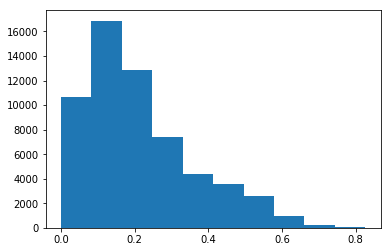

In [54]:
plt.hist(norm.reshape(np.prod(norm.shape)))

(array([ 10479.,  15127.,  12914.,   8351.,   3773.,   3023.,   3475.,
          1632.,    809.,     87.]),
 array([ 0.   ,  0.075,  0.15 ,  0.225,  0.3  ,  0.375,  0.45 ,  0.525,
         0.6  ,  0.675,  0.75 ]),
 <a list of 10 Patch objects>)

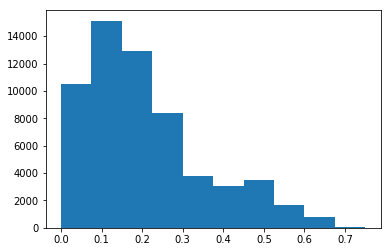

In [55]:
plt.hist(score.reshape(np.prod(score.shape)))

[ 0.51018116]
(51, 9, 13, 1)
8.46826980021


(51, 9, 13)

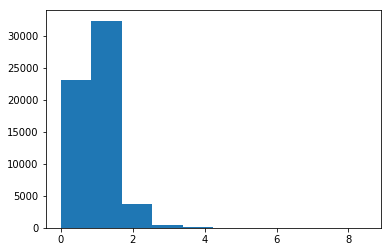

In [59]:
tmp = norm.mean(axis=-1, keepdims=True)
print(tmp[0,0,0])
print(tmp.shape)
score2 = score/norm.mean(axis=-1, keepdims=True)
plt.hist(score2.reshape(np.prod(score2.shape)))
print(np.max(score2))
med_score = np.median(score2, axis=-1)
mean_score = np.mean(score2,axis=-1)
mean_score.shape

In [ ]:
medscore = mean_score.mean(axis=0)
plt.hist(medscore.reshape(np.prod(medscore.shape)))

In [66]:
np.where(medscore > 1.06)

(array([4, 6]), array([8, 6]))

Text(0.5,1,'Median Prediction Accuracy')

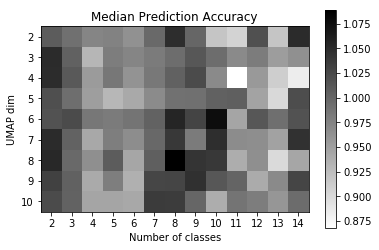

In [63]:
f, ax = plt.subplots(1)
im = ax.imshow(medscore, cmap='gray_r')
f.colorbar(im)
clusters = np.arange(2,15)
umap_dims = np.arange(2,11)
ax.set_xticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters)
ax.set_xlabel('Number of classes')
ax.set_yticks(np.arange(len(umap_dims)))
ax.set_yticklabels(umap_dims)
ax.set_ylabel('UMAP dim')
ax.set_title('Median Prediction Accuracy')

In [99]:
filename = '/Users/ahyeon/Desktop/TBIanalysis/data/data.h5'
with h5py.File(filename, 'r') as f:
    data_bm = f['data_matrix_subset_biomarker'][:].T
    data_oc = f['data_matrix_subset_outcome'][:].T
    feature_bm = f['feature_name_subset_biomarker'][:]
    feature_oc = f['feature_name_subset_outcome'][:]
    pid = f['patient_id'][:]

In [100]:
k=8
c=8
confmat = np.zeros((8,8))

embedding = run_umap(data_oc, k, n_neighbors=10,min_dist=0.001)
Z = hierarchy.linkage(embedding, 'ward', optimal_ordering=True)
labels = hierarchy.cut_tree(Z, n_clusters=c).reshape(247)


rf = RFC(100)

testX, trainX, testY, trainY = train_test_split(data_oc, labels, test_size=0.2)
rf.fit(trainX, trainY)
predictions = rf.predict(testX)
prob = rf.predict_proba(testX)
for p,a in zip(predictions, testY):
    confmat[p,a] += 1

    

Text(0.5,1,'Confusion Matrix Dim = 8')

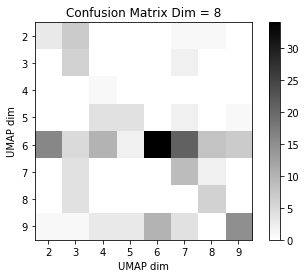

In [101]:
f, ax = plt.subplots(1)
im = ax.imshow(confmat, cmap='gray_r')
f.colorbar(im)
umap_dims = np.arange(2,10)
ax.set_xticks(np.arange(len(umap_dims)))
ax.set_xticklabels(umap_dims)
ax.set_xlabel('UMAP dim')
ax.set_yticks(np.arange(len(umap_dims)))
ax.set_yticklabels(umap_dims)
ax.set_ylabel('UMAP dim')
ax.set_title('Confusion Matrix Dim = 8')